In [1]:
import numpy as np
from astropy.modeling import models, fitting
from astropy.table import Table
from matplotlib import rcParams
rcParams['font.size'] = 12
import matplotlib.pyplot as plt
from scipy import stats
from photutils.datasets import (make_random_gaussians_table,
                                make_noise_image,
                                make_gaussian_sources_image)
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import LogStretch, SqrtStretch
norm1 = ImageNormalize(stretch=LogStretch())
norm2 = ImageNormalize(stretch=LogStretch())
norm3 = ImageNormalize(stretch=SqrtStretch())
from utils import *

np.random.seed(39)

tshape = (201, 201)
cen = ((tshape[0]-1)/2., (tshape[0]-1)/2.)
mu, sigma = 1e-2, 1e-2
noise =  make_noise_image(tshape, type='gaussian', mean=mu, stddev=sigma)
poisson_noise = np.sum([L*make_noise_image(tshape, type='poisson', mean=1e-3) 
                      for L in np.random.normal(loc=1e-2,scale=3e-3,size=20)], axis=0)
noise += poisson_noise
shot = poisson_noise[poisson_noise!=0]
poisson_frac = shot.ravel().size/noise.size
poisson_med = np.median(shot)
poisson_std =  np.std(shot)
print()
print("outlier fraction: %.3f"%(poisson_frac))


outlier fraction: 0.020


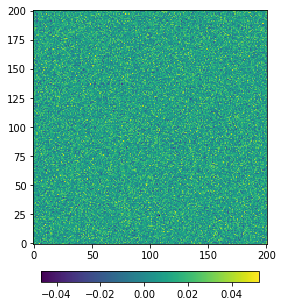

In [3]:
plt.figure(figsize=(5,5))
plt.imshow(noise, cmap='viridis', aspect=1, interpolation='nearest',origin='lower')
plt.colorbar(orientation='horizontal', fraction=0.04, pad=0.1) 

In [4]:
np.random.seed(42)
n_star = 50
star_pos = tshape[0]*np.random.random(size=(n_star,2))
star_pos

array([[ 75.28256389, 191.09357559],
       [147.1307823 , 120.33035532],
       [ 31.35974673,  31.35489859],
       [ 11.67480605, 174.1014053 ],
       [120.82411736, 142.32258814],
       [  4.13748335, 194.95188028],
       [167.3209708 ,  42.68016125],
       [ 36.54681841,  36.86430648],
       [ 61.15269083, 105.47604276],
       [ 86.82094875,  58.53705718],
       [122.98243184,  28.03826599],
       [ 58.72107436,  73.6387305 ],
       [ 91.67006683, 157.82036824],
       [ 40.13443021, 103.36112212],
       [119.07532834,   9.33653296],
       [122.11651523,  34.27534886],
       [ 13.07537019, 190.72599299],
       [194.09203865, 162.48786697],
       [ 61.2273676 ,  19.63209492],
       [137.53083833,  88.47065124],
       [ 24.5296852 ,  99.53055893],
       [  6.91209274, 182.77340082],
       [ 52.0147763 , 133.16697916],
       [ 62.65392629, 104.53367226],
       [109.88876615,  37.15574556],
       [194.88651018, 155.8016975 ],
       [188.83928725, 179.86029744],
 

In [5]:
yy, xx = np.mgrid[:tshape[0], :tshape[1]]
dist_maps = [np.sqrt((xx-x0)**2+(yy-y0)**2) for (x0,y0) in star_pos]
dist_map = np.sqrt((xx-cen[0])**2+(yy-cen[1])**2)

In [6]:
def power1d(x, n, theta, I_theta): 
    x[x<=0] = x[x>0].min()
    a = I_theta/(theta)**(-n)
    y = a * np.power(x, -n)
    return y

def power2d(x, y, n, theta, I_theta, cen=cen): 
    d = np.sqrt((x-cen[0])**2+(y-cen[1])**2)
    a = I_theta/(theta)**(-n)
    d[d<=0] = d[d>0].min()
    z = a * np.power(d, -n) 
    return z 

In [7]:
np.random.seed(512)
Amps = np.random.lognormal(mean=np.log(20),sigma=1.5, size=n_star)
A, gamma, alpha = 100, 3, 3
n, theta = 2, 5

moffat2d_s = [models.Moffat2D(amplitude=amp, x_0=x0, y_0=y0, gamma=gamma, alpha=alpha) 
              for (amp,(x0,y0)) in zip(Amps, star_pos)]
moffat1d_s = [models.Moffat1D(amplitude=amp, x_0=0, gamma=gamma, alpha=alpha) 
              for (amp,(x0,y0)) in zip(Amps, star_pos)]
mask  = ~np.logical_and.reduce([d_maps>3*gamma for d_maps in dist_maps])

array([1.50000267e+01, 1.35116187e+01, 1.88682228e+00, 2.80792398e+00,
       1.37455646e+01, 8.10473104e+00, 8.95027676e+02, 2.92056002e+00,
       7.04811452e+01, 6.89432342e+00, 6.72722217e+01, 2.85488491e+01,
       7.53442031e+00, 3.51988203e+02, 1.72444441e+01, 3.03838733e+01,
       1.89238975e+01, 2.80718045e+01, 8.42354801e+01, 2.33755006e+01,
       2.20306078e+00, 8.58767209e+01, 4.00441554e+01, 1.74863118e+02,
       2.46269539e+03, 1.04925794e+01, 9.75742401e+00, 3.08907079e+01,
       1.66956219e+00, 5.23632231e+00, 4.32753796e+00, 1.43685729e+01,
       5.15543750e+00, 9.81619345e+00, 1.58303998e+01, 2.90666562e+01,
       1.07656633e+01, 1.38621129e+02, 3.62745249e+01, 3.61266864e+01,
       2.15036029e+01, 8.94832201e+02, 7.92711089e+01, 1.68153847e+01,
       6.70806221e+00, 2.22639239e+01, 1.84717059e+01, 5.38454113e+01,
       3.92967761e+00, 4.98617862e+00])

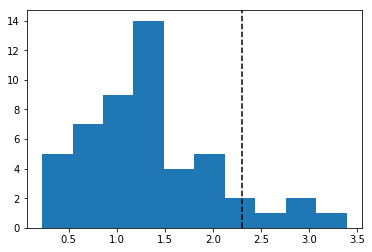

In [8]:
plt.hist(np.log10(Amps), density=False)
plt.axvline(np.log10(200),color="k",ls="--")
Amps

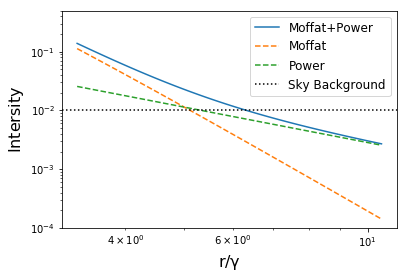

In [9]:
r = np.logspace(1,1.5,100)

moffat1d = models.Moffat1D(amplitude=200, x_0=0, gamma=gamma, alpha=alpha)
# Moffat2d(r(x,y)) = Moffat1d(r)
plt.semilogy(r/gamma, moffat1d(r) + power1d(r, n, theta=theta*gamma, I_theta=moffat1d(theta*gamma)),label="Moffat+Power")
plt.semilogy(r/gamma, moffat1d(r),ls="--",label="Moffat")
plt.semilogy(r/gamma, power1d(r, n, theta=theta*gamma, I_theta=moffat1d(theta*gamma)),ls="--",label="Power")
plt.axhline(mu,color="k",ls=":",label="Sky Background")
plt.legend(fontsize=12)
plt.ylim(1e-4,0.5)
plt.xlabel(r"$\rm r/\gamma$",fontsize=16)
plt.ylabel(r"$\rm Intersity$",fontsize=16)
plt.xscale("log")

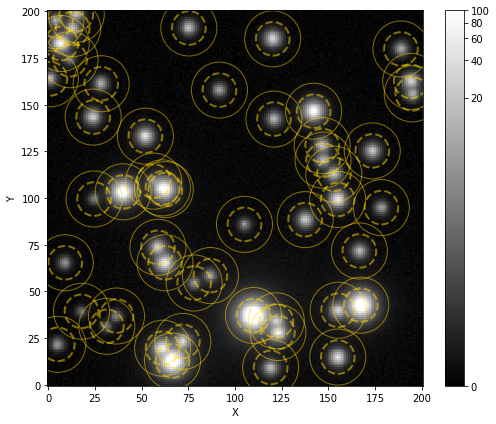

In [10]:
image = noise + np.sum([m2d(xx,yy) for m2d in moffat2d_s] ,axis=0) \
        + np.sum([power2d(xx, yy, n, cen=(x0,y0),
                          theta=theta*gamma, I_theta=m1d(theta*gamma)) 
                  for ((x0,y0),m1d) in zip(star_pos, moffat1d_s)], axis=0)

plt.figure(figsize=(7,6))
ax = plt.subplot(111)
plt.imshow(image, cmap='gray', aspect='equal', norm=norm1, vmin=0, vmax=100, interpolation='None',origin='lower') # saturate at 100 to emphasize background
plt.colorbar(fraction=0.045, pad=0.05) 

from photutils import CircularAperture, CircularAnnulus
aper1 = CircularAperture(star_pos, r=3*gamma)
aper2 = CircularAperture(star_pos, r=5*gamma)
aper1.plot(color='gold',ls="--",lw=2,alpha=0.5)
aper2.plot(color='gold',lw=1,label="",alpha=0.5)
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()

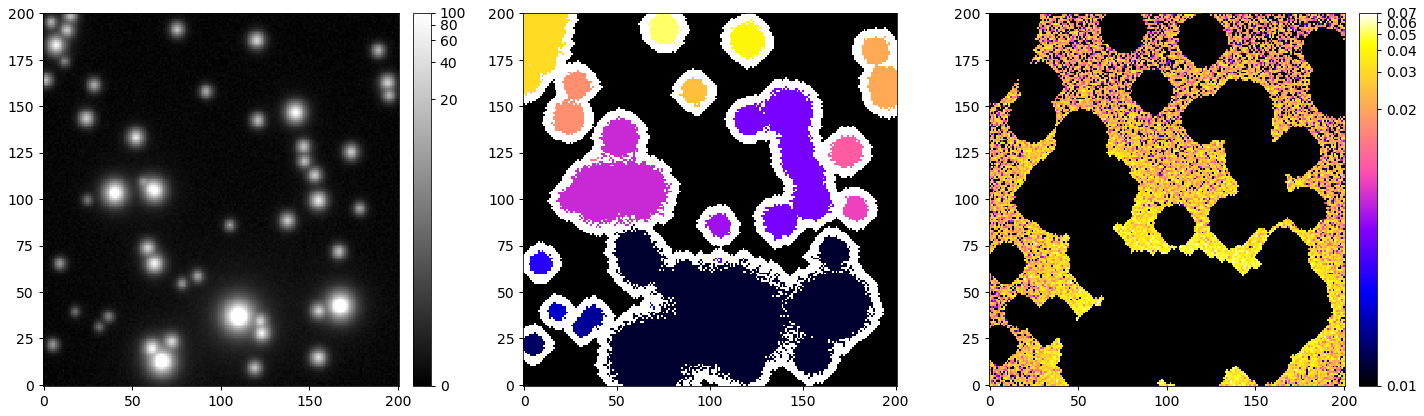

In [20]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(20,6))
im1 = ax1.imshow(image, origin='lower', cmap='gray', norm=norm2, vmin=0., vmax=100, aspect='auto')
colorbar(im1)

from photutils import detect_sources
back, back_rms = background_sub_SE(image, b_size=25)
threshold = back + (2.5 * back_rms)
segm0 = detect_sources(image, threshold, npixels=5)
from skimage import morphology
segmap = segm0.data.copy()
for i in range(5):
    segmap = morphology.dilation(segmap)
segmap2 = segm0.data.copy()
segmap2[(segmap!=0)&(segm0.data==0)] = segmap.max()+1
ax2.imshow(segmap2, origin="lower", cmap="gnuplot2")

image2 = image.copy()
mask_deep = (segmap!=0)
image2[mask_deep] = 0
im3 = ax3.imshow(image2, cmap='gnuplot2', norm=norm1, aspect='auto', vmin=1e-2, vmax=0.07, interpolation='None',origin='lower') 
colorbar(im3)
aper = CircularAperture(star_pos, r=5*gamma)
aper.plot(color='gold',lw=1,label="")

plt.tight_layout()

## Nested Bayesian 

In [13]:
import dynesty
import time
from dynesty import plotting as dyplot

from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '5.0'})
rcParams.update({'xtick.major.size': '4'})
rcParams.update({'xtick.major.width': '1.'})
rcParams.update({'xtick.minor.pad': '5.0'})
rcParams.update({'xtick.minor.size': '4'})
rcParams.update({'xtick.minor.width': '0.8'})
rcParams.update({'ytick.major.pad': '5.0'})
rcParams.update({'ytick.major.size': '4'})
rcParams.update({'ytick.major.width': '1.'})
rcParams.update({'ytick.minor.pad': '5.0'})
rcParams.update({'ytick.minor.size': '4'})
rcParams.update({'ytick.minor.width': '0.8'})
rcParams.update({'font.size': 14})

In [21]:
# gamma, alpha, n, a, mu, sigma
truths = n, theta, np.log10(mu), np.log10(sigma)
labels = [r'$n$', r'$\theta$', r'$\log\,\,\mu$', r'$\log\,\,\sigma$']
truths

def prior_transform(u):
    v = u.copy()
    v[0] = u[0] * 4 + 1  # n : 1-5
    v[1] = u[1] * 7. + 3  # theta : 3-10
    v[2] = u[2] * 2 - 3  # mu : 1e-3 - 1e-1
    v[3] = u[3] * 2 - 3  # sigma : 1e-3 - 1e-1
    return v

mask_fit = mask_deep.copy()
X = np.array([xx,yy])
Y = image[~mask_fit].ravel()
xx, yy = X[0], X[1]
mof_comp = np.sum([m(xx,yy) for m in moffat2d_s] ,axis=0)
    
def loglike(v):
    n, theta, log10_mu, log10_sigma = v
    mu, sigma = (10**log10_mu, 10**log10_sigma)
    pow_comp = np.sum([power2d(xx, yy, n, cen=(x0,y0), 
                               theta=theta*gamma, I_theta=m1d(theta*gamma))
                       for ((x0,y0),m1d) in zip(star_pos, moffat1d_s)], axis=0)
    ypred = (mof_comp + pow_comp + mu)[~mask_fit].ravel()
    residsq = (ypred - Y)**2 / sigma**2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma**2))
    
    if not np.isfinite(loglike):
        loglike = -1e100
        
    return loglike

In [485]:
# gamma, alpha, n, a, mu, sigma
truths = n, theta, np.log10(mu), np.log10(sigma), poisson_frac, np.log10(poisson_med), np.log10(poisson_std)
labels = [r'$n$', r'$\theta$', r'$\log\,\,\mu$', r'$\log\,\,\sigma$',
          r'$p_{out}$', r'$\log\,\,\mu_{out}$', r'$\log\,\,\sigma_{out}$']
truths

def prior_transform(u):
    v = u.copy()
    v[0] = u[0] * 4 + 1  # n : 1-5
    v[1] = u[1] * 7. + 3  # theta : 3-10
    v[2] = u[2] * 2 - 3  # mu : 1e-3 - 1e-1
    v[3] = u[3] * 2 - 3  # sigma : 1e-3 - 1e-1
    v[4] = u[4] * 0.3 + 0.001  # p_out : 0.001 - 0.3
    v[5] = u[5] * 2 - 3  # mu_out : 1e-3 - 1e-1
    v[6] = u[6] * 2 - 3  # sigma_out : 1e-3 - 1e-1
    return v

mask_fit = mask_deep.copy()

X = np.array([xx,yy])
Y = image[~mask_fit].ravel()
xx, yy = X[0], X[1]
mof_comp = np.sum([m(xx,yy) for m in moffat2d_s] ,axis=0)
    
def loglike_outlier(v):
    n, theta, log10_mu, log10_sigma, p_out, log10_mu_out, log10_sigma_out = v
    mu, sigma, mu_out, sigma_out = (10**log10_mu, 10**log10_sigma, 10**log10_mu_out, 10**log10_sigma_out)
    pow_comp = np.sum([power2d(xx, yy, n, cen=(x0,y0), 
                               theta=theta*gamma, I_theta=m1d(theta*gamma))
                       for ((x0,y0),m1d) in zip(star_pos, moffat1d_s)], axis=0)
    ypred = (mof_comp + pow_comp)[~mask_fit].ravel()
    
    residsq_int = (ypred + mu - Y)**2 / (2 * sigma**2)
    residsq_out = (ypred + mu_out - Y)**2 / (2 * sigma_out**2)
    
    log_prob_int = residsq_int - np.log(sigma) + np.log(1-p_out)
    log_prob_out = residsq_out - np.log(sigma_out) + np.log(p_out)
    
#     if (False in np.isfinite(prob_int)) | (False in np.isfinite(prob_out)):
#         loglike = -1e100
    
    loglike = -np.sum(np.log(np.exp(log_prob_int) + np.exp(log_prob_out)))
    
    if not np.isfinite(loglike):
        loglike = -1e100
        
    return loglike

### MP

In [22]:
import multiprocess as mp
import time
import os
print(os.cpu_count())

4


In [30]:
mypool = mp.Pool(4)
mypool.size = 4

### No Outlier

In [499]:
dlogz = 1e-3 * (200 - 1) + 0.01
start=time.time()
pdsampler = dynesty.DynamicNestedSampler(loglike, prior_transform, 4,
                                          pool=mypool, use_pool={'update_bound': False})
pdsampler.run_nested(nlive_init=200, nlive_batch=200, maxbatch=4,
                      dlogz_init=dlogz, wt_kwargs={'pfrac': 0.8})
end=time.time()

print("%.3gs"%(end-start))
pdres = pdsampler.results

iter: 9102 | batch: 4 | bound: 70 | nc: 1 | ncall: 27967 | eff(%): 32.546 | loglstar: 95057.445 < 95062.092 < 95057.929 | logz: 95037.241 +/-  0.333 | stop:  2.039                                   

4.52e+03s


(2, 5, -2.0, -2.0)


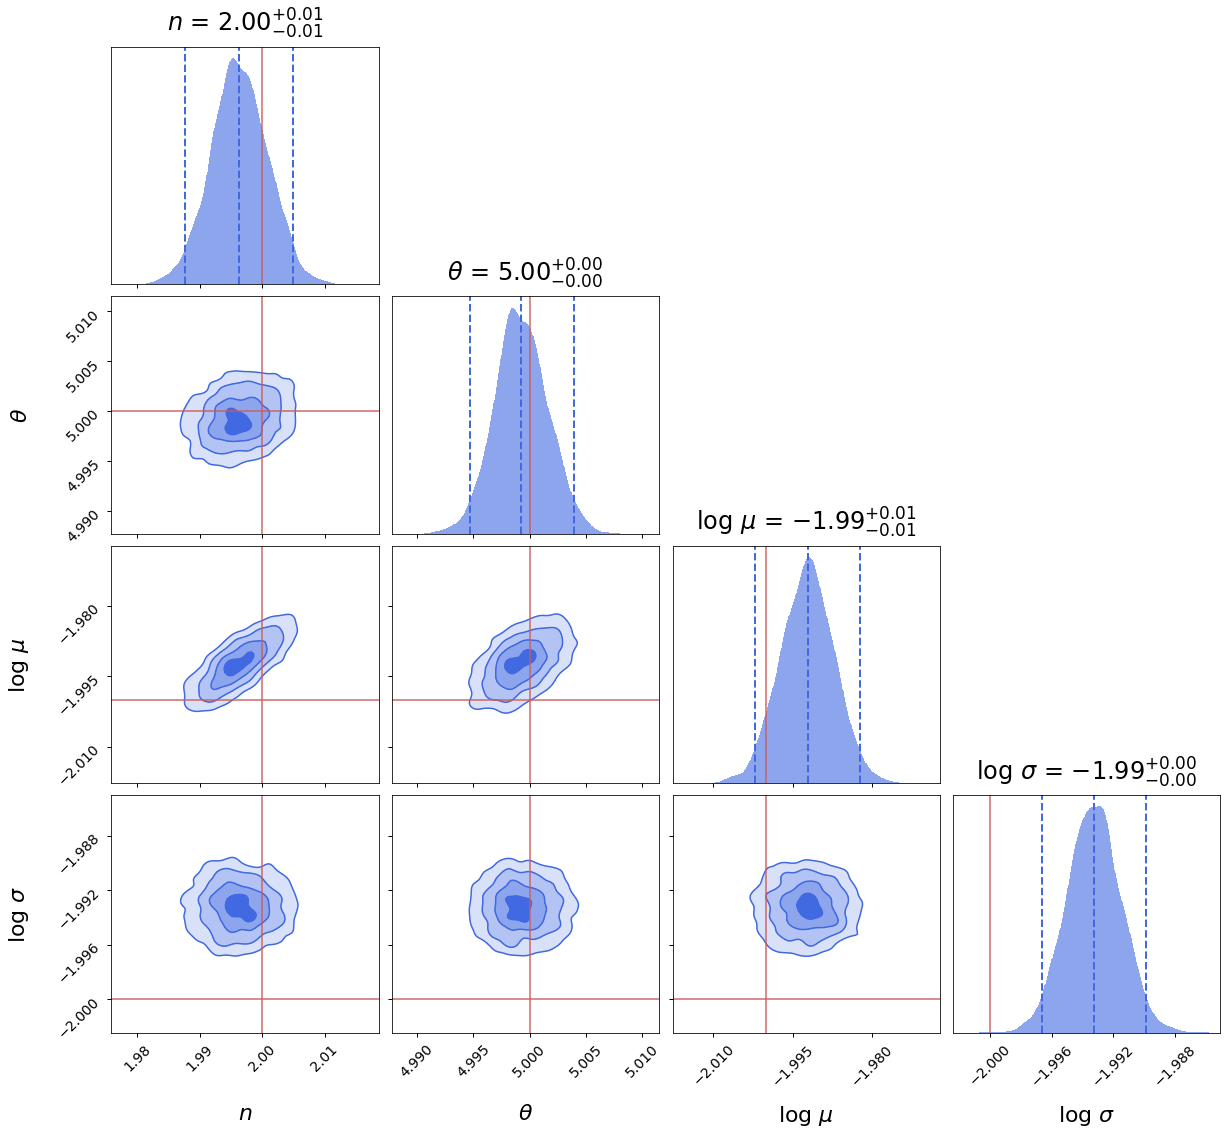

In [500]:
# With Poisson Noise
print(truths)
fig, axes = dyplot.cornerplot(pdres, truths=truths, show_titles=True, 
                              color="royalblue", truth_color="indianred",
                              title_kwargs={'fontsize':24, 'y': 1.04}, labels=labels,
                              label_kwargs={'fontsize':22},
                              fig=plt.subplots(4, 4, figsize=(18, 16)))

In [29]:
mypool.close()

### With Outlier

In [488]:
dlogz = 1e-3 * (200 - 1) + 0.01
start=time.time()
pdsampler3 = dynesty.DynamicNestedSampler(loglike_outlier, prior_transform, 7, sample='slice', 
                                          pool=mypool, use_pool={'update_bound': False})
pdsampler3.run_nested(nlive_init=200, nlive_batch=200, maxbatch=4,
                      dlogz_init=dlogz, wt_kwargs={'pfrac': 0.8})
end=time.time()

print("%.3gs"%(end-start))
pdres3 = pdsampler3.results

iter: 8700 | batch: 4 | bound: 243 | nc: 193 | ncall: 1587224 | eff(%):  0.548 | loglstar: -39567.459 < -39561.806 < -39566.746 | logz: -39587.978 +/-    nan | stop:  2.205                          


1.73e+05s


(2, 5, -2.0, -2.0, 0.019801490062127176, -2.0501595876369065, -2.410044398348979)


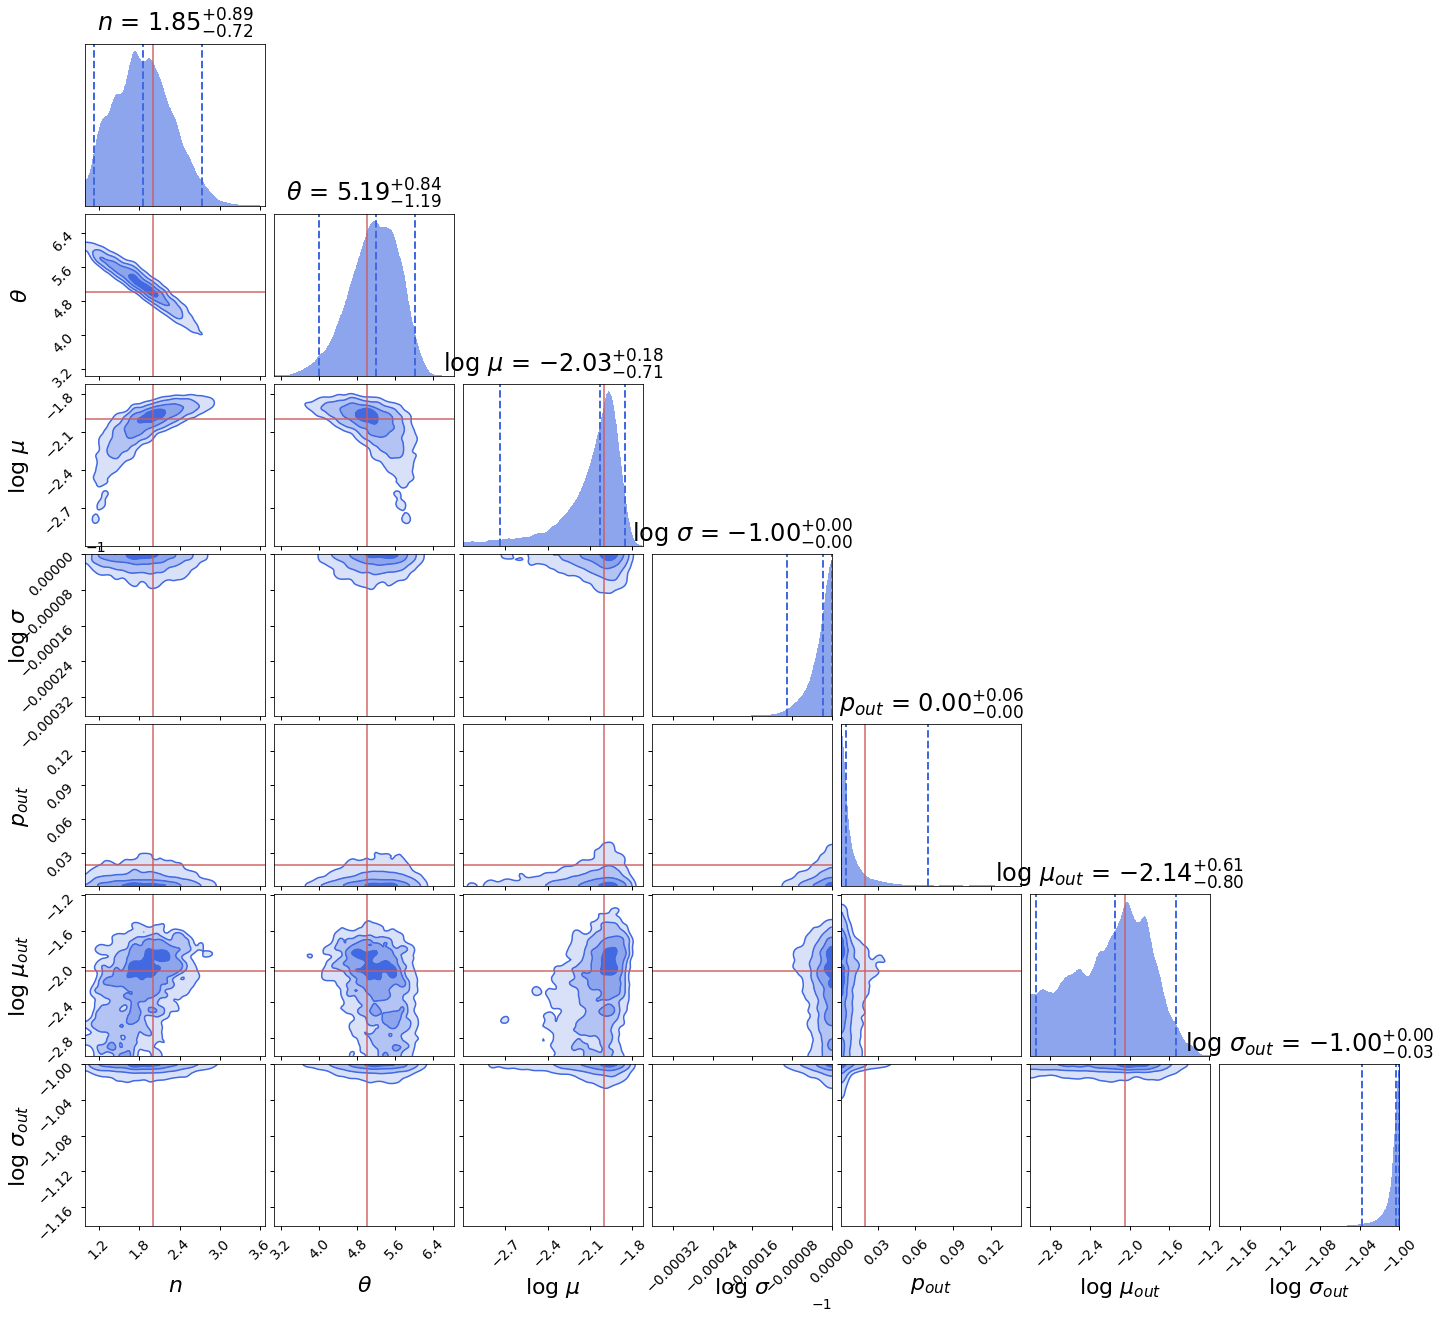

In [492]:
print(truths)
fig, axes = dyplot.cornerplot(pdres3, truths=truths, show_titles=True, 
                              color="royalblue", truth_color="indianred",
                              title_kwargs={'fontsize':24, 'y': 1.04}, labels=labels,
                              label_kwargs={'fontsize':22},
                              fig=plt.subplots(7, 7, figsize=(20, 18)))

In [501]:
mypool.close()

### Continue sampling

In [22]:
pdsampler3.run_nested(nlive_batch=200, maxbatch=10,
                      dlogz_init=dlogz, wt_kwargs={'pfrac': 0.8})
pdres3 = pdsampler3.results

iter: 13428 | batch: 10 | bound: 123 | nc: 1 | ncall: 42593 | eff(%): 31.526 | loglstar: 111433.622 < 111440.617 < 111439.720 | logz: 111415.900 +/-  0.331 | stop:  1.429                            


(2, 5, -2.0, -2.0)


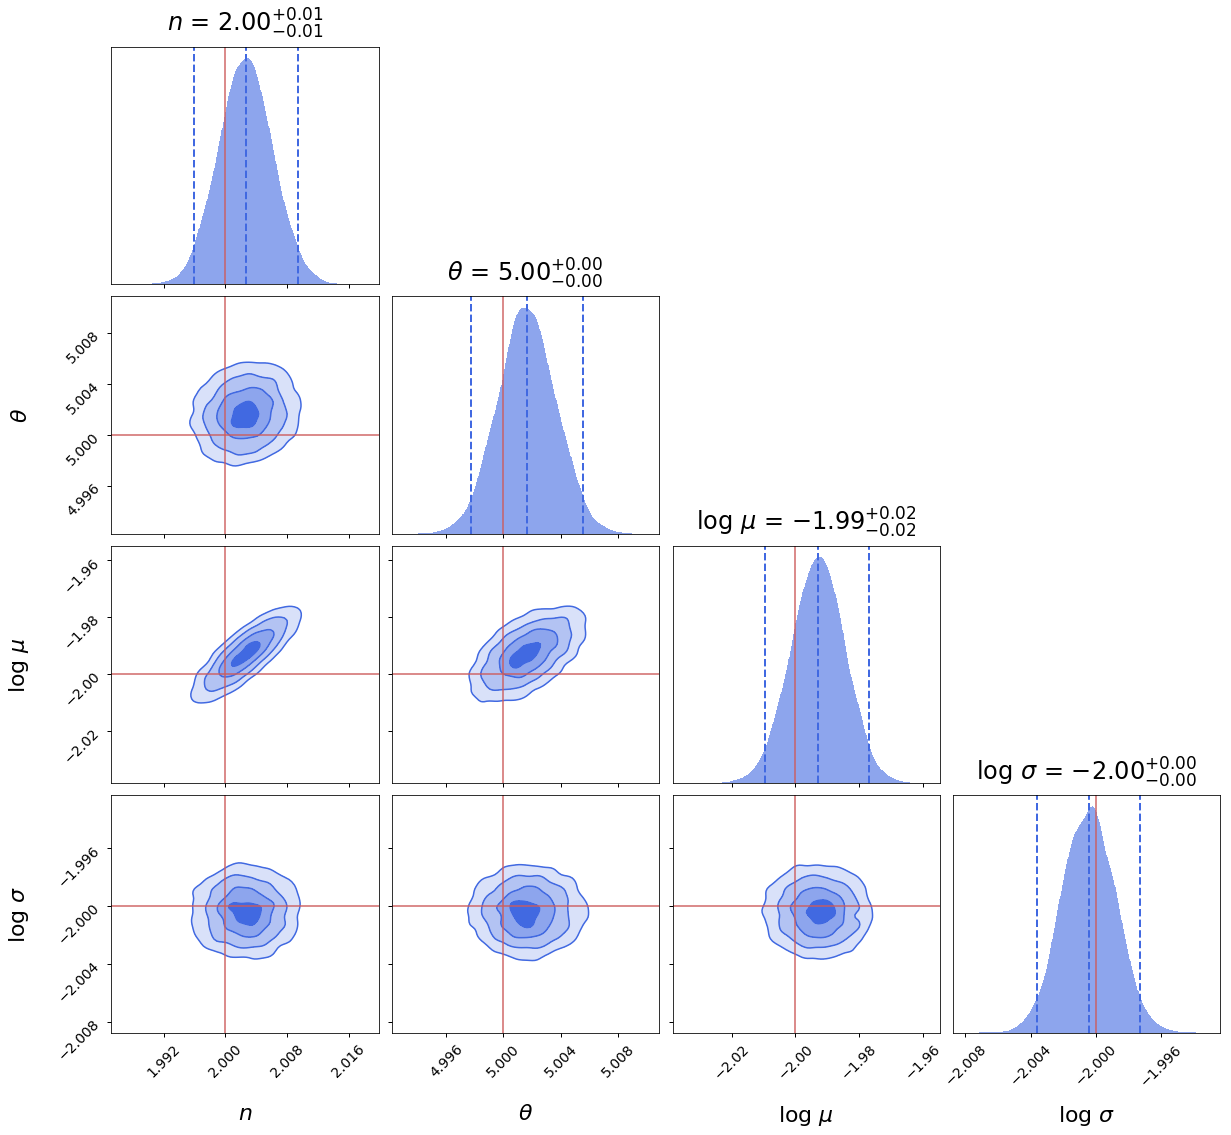

In [23]:
print(truths)
fig, axes = dyplot.cornerplot(pdres3, truths=truths, show_titles=True, 
                              color="royalblue", truth_color="indianred",
                              title_kwargs={'fontsize':24, 'y': 1.04}, labels=labels,
                              label_kwargs={'fontsize':22},
                              fig=plt.subplots(4, 4, figsize=(18, 16)))

In [483]:
mypool.close()  # How to continue sample after the pool is closed?

## Deep Mask

In [231]:
dlogz = 1e-3 * (200 - 1) + 0.01
start=time.time()
pdsampler3 = dynesty.DynamicNestedSampler(loglike, prior_transform, 4, 
                                          pool=mypool, use_pool={'update_bound': False})
pdsampler3.run_nested(nlive_init=200, nlive_batch=200, maxbatch=4,
                      dlogz_init=dlogz, wt_kwargs={'pfrac': 0.8})
end=time.time()

print("%.3gs"%(end-start))
pdres3 = pdsampler3.results

iter: 8319 | batch: 4 | bound: 76 | nc: 1 | ncall: 30075 | eff(%): 27.661 | loglstar: 68467.493 < 68472.266 < 68468.011 | logz: 68450.792 +/-  0.307 | stop:  2.461                                   


2.55e+03s


(2, 5, -2.0, -2.0)


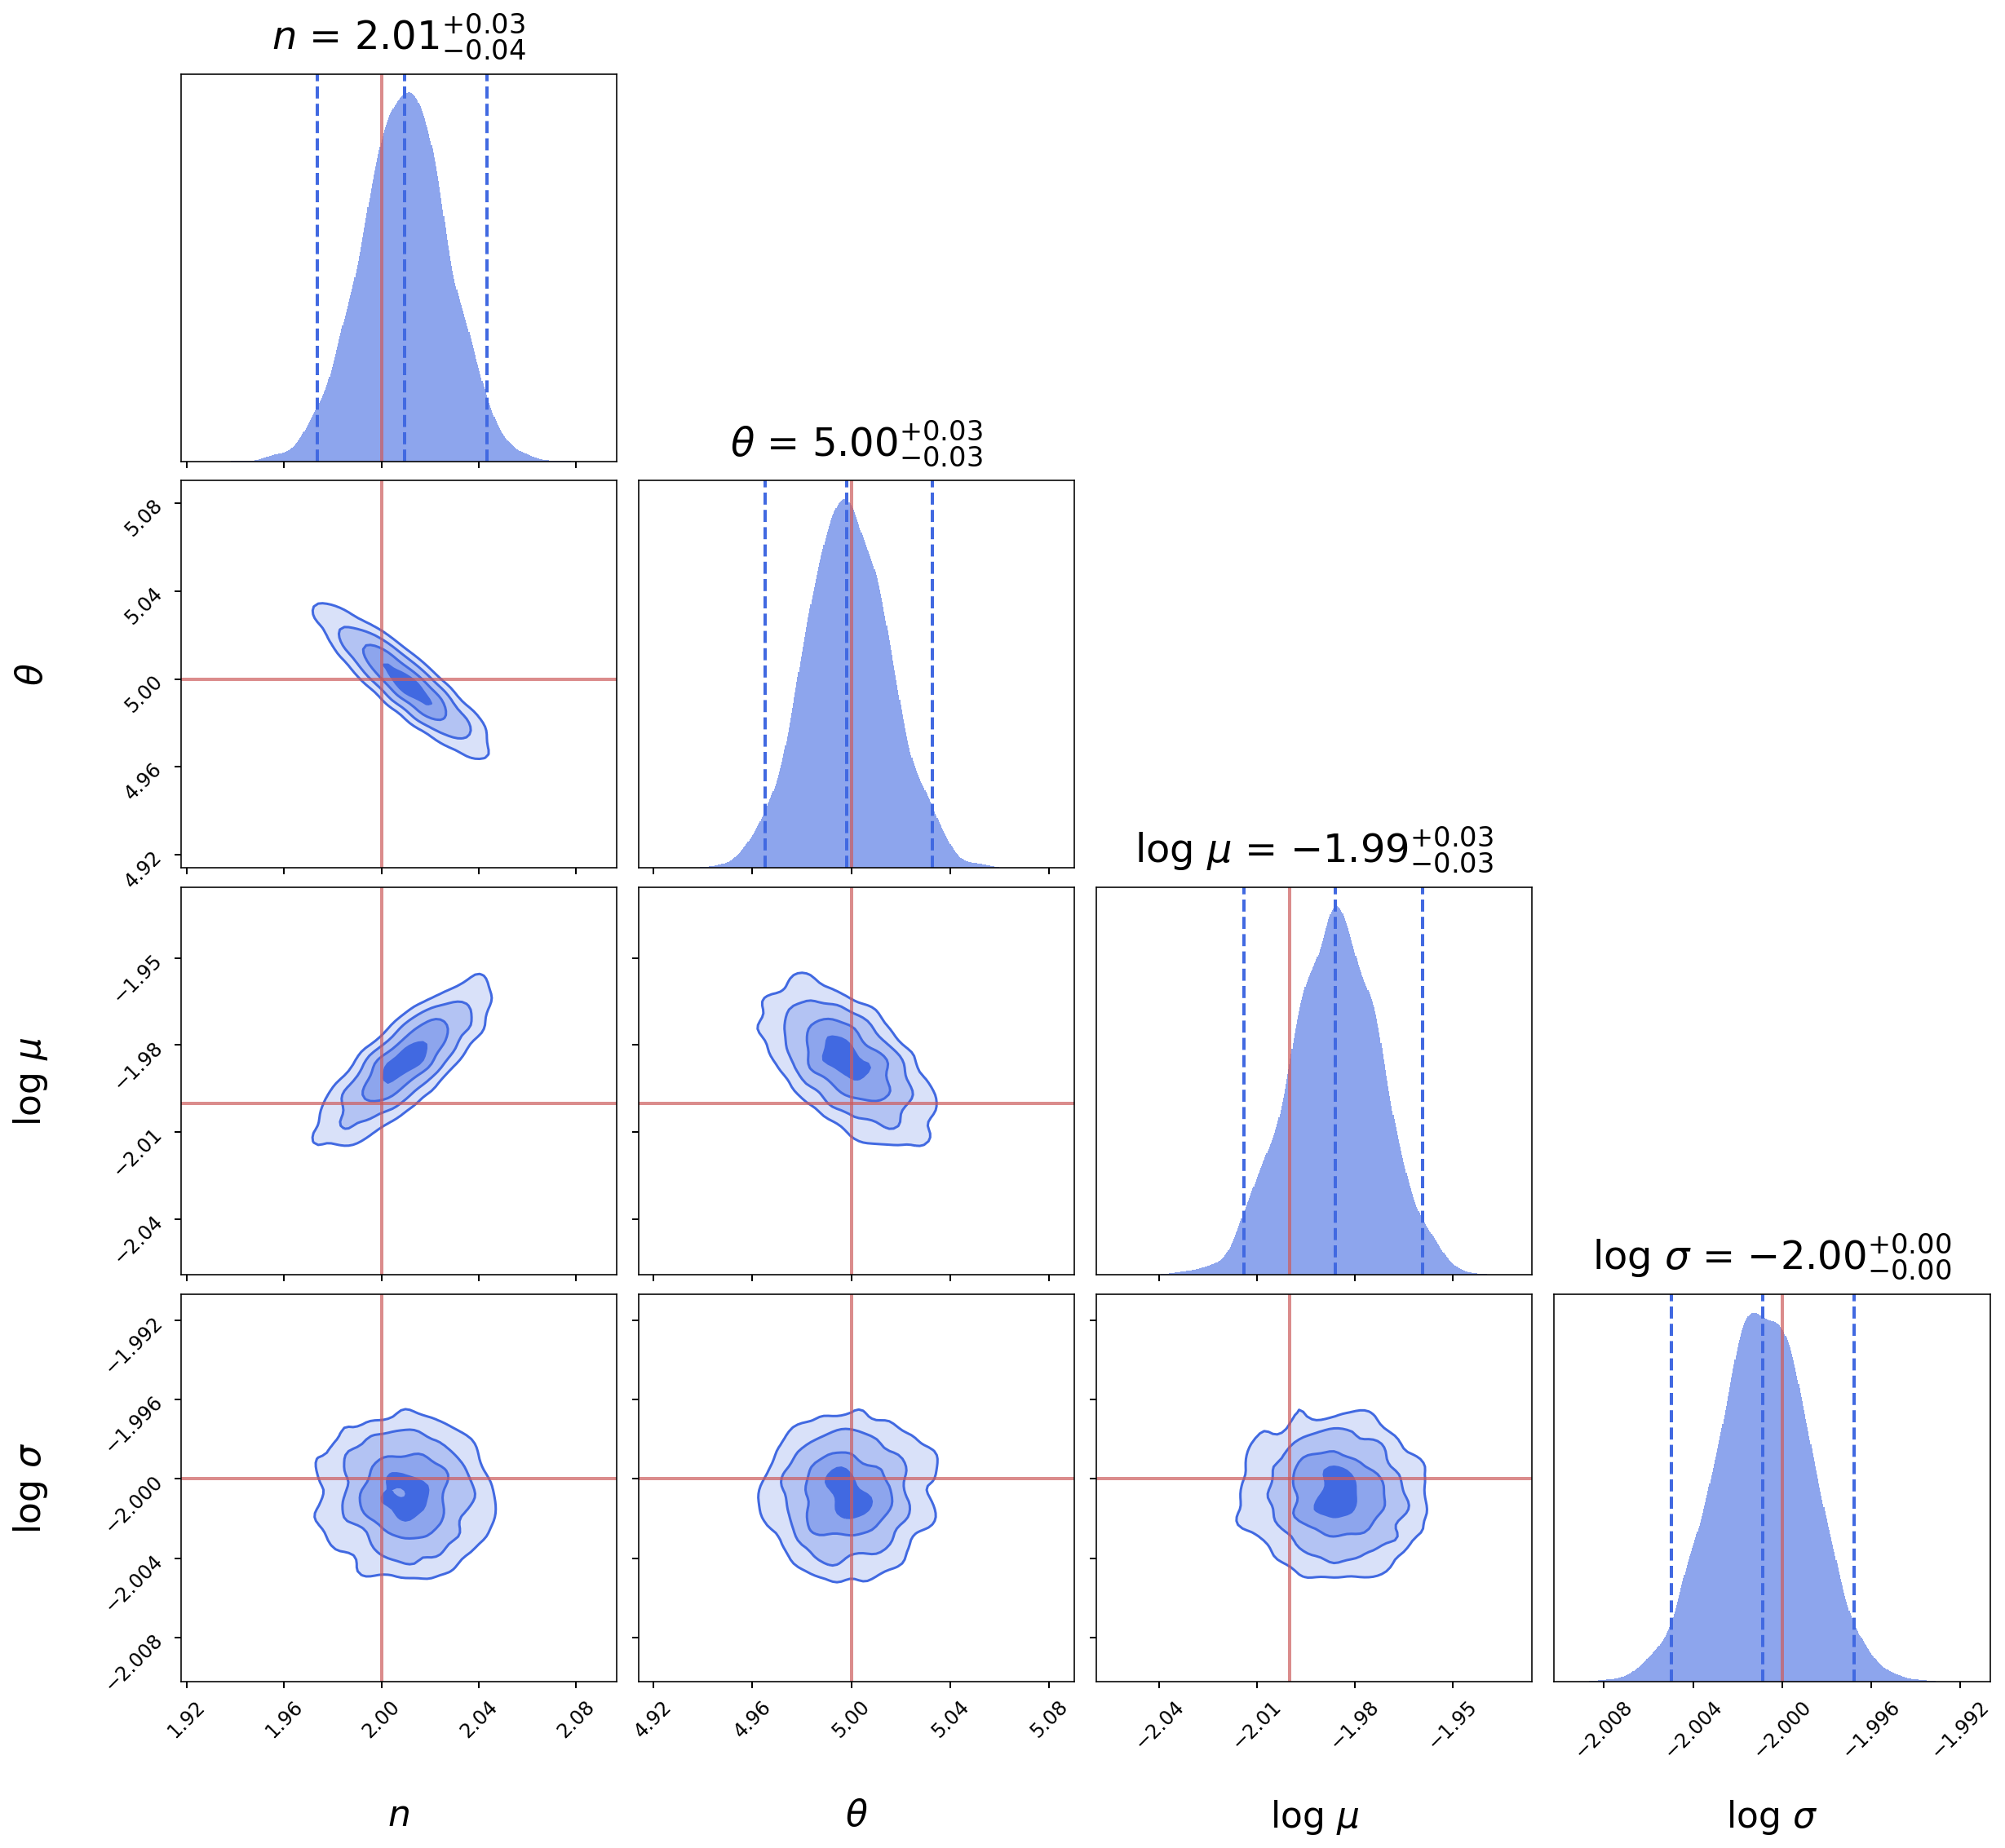

In [232]:
print(truths)
fig, axes = dyplot.cornerplot(pdres3, truths=truths, show_titles=True, 
                              color="royalblue", truth_color="indianred",
                              title_kwargs={'fontsize':24, 'y': 1.04}, labels=labels,
                              label_kwargs={'fontsize':22},
                              fig=plt.subplots(4, 4, figsize=(18, 16)))